### Image Prediction Analysis

This notebook provides a close-up examination of the images that each experimental trial predicts correctly and incorrectly.  It then offers a comparative analysis to look for trends and conclusions.


##### Import Libraries and Modules

In [1]:
from ast import literal_eval
import os
import re
import pandas as pd
from glob import glob
from pathlib import Path
from collections import Counter 
import numpy as np
import torchvision
from PIL import Image
import seaborn as sns
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

pd.set_option('display.max_rows', 500)

##### Retrieve Results from directory

In [2]:
search_path = "../model_results"
file_extension = "*.csv"

dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

df_orig = pd.concat(dfs, ignore_index=True)
df_orig['Accuracy'] = df_orig['Accuracy'].apply(lambda x: x*100)
#df_orig['Original_CI'] = df_orig.Original_CI.apply(lambda x: literal_eval(x))
#df_orig['Orig_CI_Low'], df_orig['Orig_CI_Hi'] = zip(*df_orig.Original_CI)

# Filter data into subsets based on test dataset used
df_orig_cifar10 = df_orig[df_orig['Testset'] == 'cifar10']
df_orig_cifar101 = df_orig[df_orig['Testset'] == 'cifar10.1']

In [3]:
df_orig.head()

,Model,Epoch,Testset,Loss,Accuracy,Original_Accuracy_300epochs,Original_CI_300epochs,Original_Accuracy,Original_CI
0,resnext_29_4x64d_ra_1_20,400,cifar10,0.4082,87.85,96.4,"(96.0, 96.7)",NaN,NaN
1,resnext_29_4x64d_ra_1_20,400,cifar10.1,0.8135,77.20,89.6,"(88.2, 90.9)",NaN,NaN
2,resnext_29_4x64d_ra_1_20_refined400,50,cifar10,0.2044,93.98,96.4,"(96.0, 96.7)",NaN,NaN
3,resnext_29_4x64d_ra_1_20_refined400,50,cifar10.1,0.4750,86.45,89.6,"(88.2, 90.9)",NaN,NaN
4,wrn_28_10_ra_3_20,400,cifar10,0.9243,75.99,NaN,NaN,95.9,"(95.5, 96.3)"


In [4]:
final_score_subset = df_orig[['Model', 'Accuracy', 'Testset']].sort_values(by=['Model'])

# Remove models that we did not run randaugment datasets through
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('resnet_basic_44')]
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('pyramidnet_basic_110_84')]
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('resnext_29_8x64d')]


final_score_subset['ra'] = final_score_subset['Model'].str.contains("ra_")

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        M = int(srch3.group(2))
    return M

final_score_subset['N'] = final_score_subset.apply(lambda row: ra_N_extraction(row), axis=1)
final_score_subset['M'] = final_score_subset.apply(lambda row: ra_M_extraction(row), axis=1)
cols = ['N', 'M']
final_score_subset['hue'] = final_score_subset[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


#final_score_subset[final_score_subset['Model'].str.contains("refined300")]
final_score_subset

,Model,Accuracy,Testset,ra,N,M,hue
85,densenet_BC_100_12,88.75,cifar10,False,0,0,0_0
86,densenet_BC_100_12,94.56,cifar10,False,0,0,0_0
87,densenet_BC_100_12,94.84,cifar10,False,0,0,0_0
88,densenet_BC_100_12,88.30,cifar10.1,False,0,0,0_0
160,densenet_BC_100_12_cm_1_.5,30.93,cifar10,False,0,0,0_0
161,densenet_BC_100_12_cm_1_.5,27.10,cifar10.1,False,0,0,0_0
163,densenet_BC_100_12_cm_1_.5_refined400,93.74,cifar10,False,0,0,0_0
162,densenet_BC_100_12_cm_1_.5_refined400,86.30,cifar10.1,False,0,0,0_0
10,densenet_BC_100_12_cm_1_1,90.55,cifar10,False,0,0,0_0
11,densenet_BC_100_12_cm_1_1,82.50,cifar10.1,False,0,0,0_0


IndexError: list index out of range

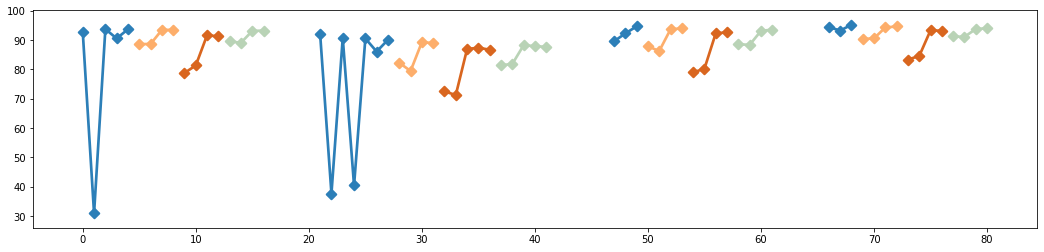

In [5]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]
#sns.palplot(sns.color_palette(flatui))


f, ax = plt.subplots(figsize=(18, 4))
sp = sns.pointplot(x="Model", hue="hue", y="Accuracy", data=final_score_subset[final_score_subset['Testset'] == 'cifar10'], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  
plt.xlabel('Model', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
#plt.title("Model Accuracy", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.set_style()

sp = sns.pointplot(x="Model", hue="hue", y="Accuracy", data=final_score_subset[final_score_subset['Testset'] == 'cifar10.1'], 
                   markers=['o']*4, linestyles=['--']*4, palette=flatui, ci=None,alpha=0.7) # and slightly transparent

#[0, 1, 2, 3, 4, u'D', 6, 7, 8, u's', u'|', 11, u'None', u'P', 9, u'x', u'X', 5, u'_', u'^', u' ', 
# None, u'd', u'h', u'+', u'*', u',', u'o', u'.', u'1', u'p', u'3', u'2', u'4', u'H', u'v', u'', u'8', 10, u'&lt;', u'&gt;']


train_datasets = ['CIFAR 10', 'CIFAR10 RandAugment N=2,M=20', 'CIFAR10 RandAugment N=2,M=5', 'CIFAR10 RandAugment N=3,M=20']
test_datasets = ['CIFAR 10', 'CIFAR 10.1']

h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
leg = ax.legend(handles=h, labels=train_datasets,loc=(1.01,0.65), title="Training Dataset by Color")
ax.add_artist(leg)

h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
ax.legend(handles=h2, labels=train_datasets,loc=(1.01,0.4), title="Test Dataset by Marker")

# os.chdir('/home/ec2-user/SageMaker/')
# plt.savefig('error-by-token-type.png')

pass

In [6]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

# Download CIFAR-10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Retrieve the official labels of the CIFAR10.1 test dataset
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


Extracting ./data/cifar-10-python.tar.gz to ./data


## Results Analysis

##### Import all of the prediction results from the github subdirectory

In [7]:
to_be_101_df = []
to_be_10_df = []

p1 = re.compile("predictions_(.+?)(_cifar101){0,1}.npz")
p2 = re.compile("([\d]+)(_refined)?(\d*)")
p3 = re.compile("ra_(\d+)_(\d+)")

for path in Path('../model_results').rglob('*.npz'):
    model = str(path.parent)
    srch1 = p1.search((path.name).lower())
    g1 = srch1.group(1)
    epochs, refined_epochs = 0, 0
    N, M = 0, 0 
    
    if 'refined' in g1:
        epochs = 400
        srch2 = p2.search(g1, re.IGNORECASE)
        if srch2.group(2) != None:
            refined_epochs = srch2.group(3)
        else:
            refined_epochs = srch2.group(1)

    else:
        epochs = g1   
    
    testset = 'cifar101' in (path.name).lower()
    rand_aug = "ra_" in str(path.parent).lower()
    refined = "refined" in (path.name).lower()
    npzf = np.load(path)
    
    if rand_aug:
        srch3 = p3.search(model.lower())
        N = int(srch3.group(1))
        M = int(srch3.group(2))
        
    if testset:
        # Remove if statement once correct file is checked in for this dataset
        #if str(path) not in 'resnet_basic_32_ra_2_20/predictions_400_CIFAR101.npz':
        result_by_img = test_labels_CIFAR101 == npzf['labels']
        to_be_101_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M] + result_by_img.tolist())
    else:
        result_by_img = test_labels_CIFAR10 == npzf['labels']
        to_be_10_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M] 
                           + result_by_img.tolist())
        
        
results_cifar101 = pd.DataFrame(to_be_101_df) 
results_cifar101.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar101.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                   'img-4':"epochs", 'img-3':"refined_epochs",
                                   'img-2':"N", 'img-1':"M"
                                  }, inplace=True)

results_cifar10 = pd.DataFrame(to_be_10_df) 
results_cifar10.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar10.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                  'img-4':"epochs", 'img-3':"refined_epochs",
                                  'img-2':"N", 'img-1':"M"
                                 }, inplace=True)


In [8]:
results_cifar101 = results_cifar101[results_cifar101.groupby(['model'])['epochs']
                                    .transform(max) == results_cifar101['epochs']]
results_cifar10 = results_cifar10[results_cifar10.groupby(['model'])['epochs']
                                    .transform(max) == results_cifar10['epochs']]

In [9]:
print("CIFAR10 len:", len(results_cifar10), "CIFAR10.1 len:", len(results_cifar101))
results_cifar10.head()

CIFAR10 len: 85 CIFAR10.1 len: 85


,model,cifar101,randaug,epochs,refined_epochs,N,M,img0,img1,img2,...,img9990,img9991,img9992,img9993,img9994,img9995,img9996,img9997,img9998,img9999
0,../model_results/resnext_29_4x64_ra_1_20,False,True,400,50,1,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,../model_results/resnext_29_4x64_ra_1_20,False,True,400,0,1,20,True,True,True,...,True,True,True,False,True,True,True,True,True,True
2,../model_results/wrn_28_10_ra_3_20,False,True,400,50,3,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,../model_results/wrn_28_10_ra_3_20,False,True,400,0,3,20,True,True,True,...,False,True,True,True,False,False,True,True,True,True
4,../model_results/densenet_BC_100_12_cm_1_1,False,False,400,50,0,0,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [40]:
results_cifar10

,model,cifar101,randaug,epochs,refined_epochs,N,M,img0,img1,img2,...,img9990,img9991,img9992,img9993,img9994,img9995,img9996,img9997,img9998,img9999
0,../model_results/resnext_29_4x64_ra_1_20,False,True,400,50,1,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,../model_results/resnext_29_4x64_ra_1_20,False,True,400,0,1,20,True,True,True,...,True,True,True,False,True,True,True,True,True,True
2,../model_results/wrn_28_10_ra_3_20,False,True,400,50,3,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,../model_results/wrn_28_10_ra_3_20,False,True,400,0,3,20,True,True,True,...,False,True,True,True,False,False,True,True,True,True
4,../model_results/densenet_BC_100_12_cm_1_1,False,False,400,50,0,0,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,../model_results/densenet_BC_100_12_cm_1_1,False,False,400,0,0,0,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,../model_results/resnet_basic_32_ra_2_20_c10val,False,True,400,50,2,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,../model_results/resnet_basic_32_ra_2_20_c10val,False,True,400,0,2,20,True,True,True,...,False,True,True,False,True,False,True,True,True,True
8,../model_results/densenet_BC_100_12_ra_1_20,False,True,400,50,1,20,True,True,True,...,True,True,True,True,True,True,True,True,True,True
9,../model_results/densenet_BC_100_12_ra_1_20,False,True,400,0,1,20,True,True,True,...,True,True,True,False,True,False,True,True,True,True


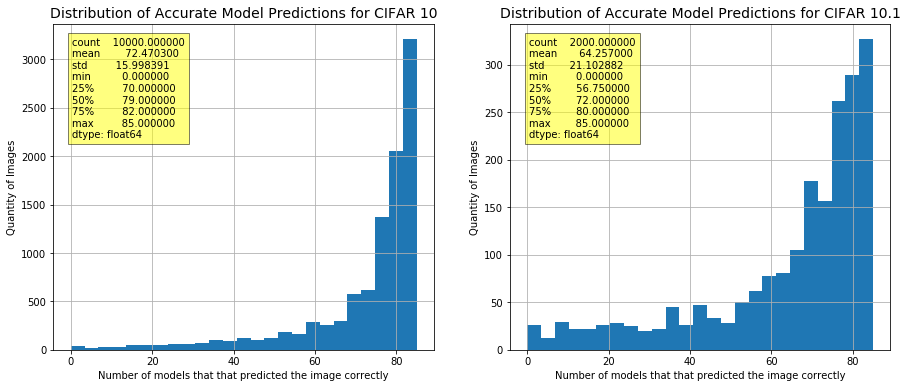

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10.columns if 'img' in col]
img_preds10 = results_cifar10[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=25)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101.columns if 'img' in col]
img_preds101 = results_cifar101[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=25)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

pass

In [11]:
def print_imgs(testset, testlabels, img_indexes):
    
    images_to_print = []
    stats = []
    
    for ii in img_indexes:
        ii = int(ii[3:])
        img_dict = {'correct_label': testlabels[ii],
                    'correct_label_id': class_dict[testlabels[ii]],
                    'img_index': ii
                   }
        
        img=Image.fromarray(testset[ii])
        images_to_print.append(img)
        
        stats.append(class_dict[testlabels[ii]])

    # Print the misclassified images
    wrong = len(img_indexes)
    last_row = [1 if wrong % 10 != 0 else 0]
    whole_rows = wrong // 10
    
    fig = plt.figure(figsize=(8 * (whole_rows + 1), 2 * (whole_rows + 1)))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(whole_rows + 1, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes
        ax.imshow(im)
        
    print("Correct Labels by Row:")
    print("\n".join([" ".join(stats[i:i+10]) for i in range(0,len(stats),10)]))

### Aggregate Results for All Models
#### Images that every model missed

###### CIFAR 10.1

On CIFAR 10.1, 8 were misclassified by every model. That is 0.004 percent of the dataset.

Correct Labels by Row:
automobile automobile automobile automobile automobile cat dog horse


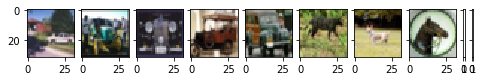

In [12]:
# Print the images that no model got right
zero = img_preds101[img_preds101 == 0]
print("On CIFAR 10.1,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())

##### CIFAR 10

On CIFAR 10, 7 were misclassified by every model. That is 0.0007 percent of the dataset.

Correct Labels by Row:
airplane truck horse horse cat bird automobile


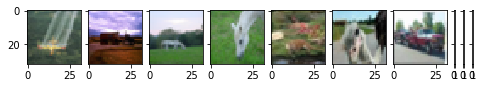

In [13]:
# Print the images that no model got right
zero = img_preds10[img_preds10 == 0]
print("On CIFAR 10,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())

#### Images that 5 models or less predicted correctly

##### CIFAR 10.1

On CIFAR 10.1, 35 were misclassified by 0 - 5 models. That is 0.0175 percent of the dataset.

Correct Labels by Row:
airplane airplane airplane airplane automobile automobile automobile automobile automobile automobile
automobile automobile automobile automobile automobile automobile automobile automobile automobile bird
cat cat cat cat cat dog dog dog dog dog
horse horse horse ship truck


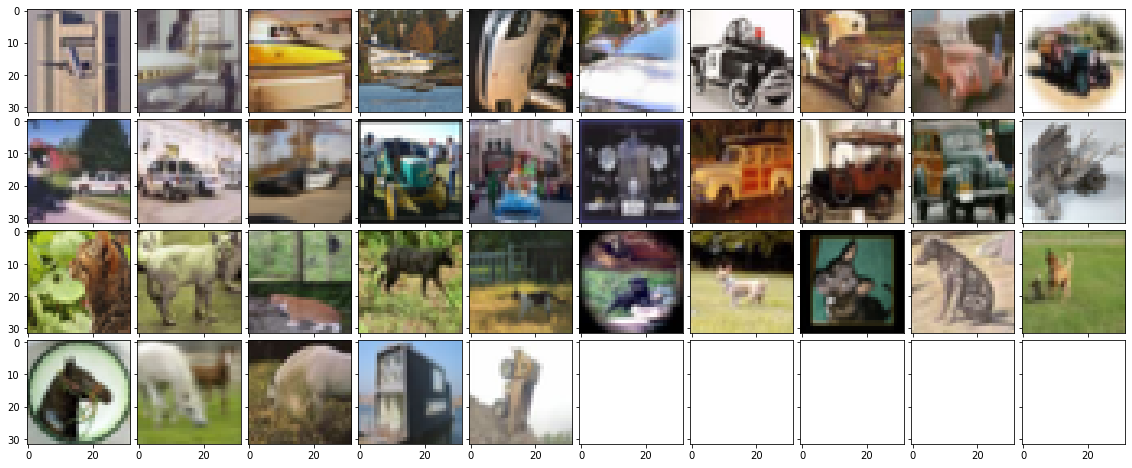

In [14]:
# Print the images that 5 models or less got right
threshold = 5
zero = img_preds101[img_preds101 <= threshold]
print("On CIFAR 10.1,", len(zero), "were misclassified by 0 -", threshold, "models. That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())

##### CIFAR 10

On CIFAR 10, 55 were misclassified by 0 - 5 models. That is 0.0055 percent of the dataset.

Correct Labels by Row:
bird airplane frog dog cat bird dog ship frog horse
deer airplane cat truck dog dog bird cat horse cat
dog dog automobile frog deer truck horse horse truck truck
dog cat truck cat dog horse dog truck deer cat
cat automobile cat bird bird automobile frog horse cat dog
automobile horse horse bird dog


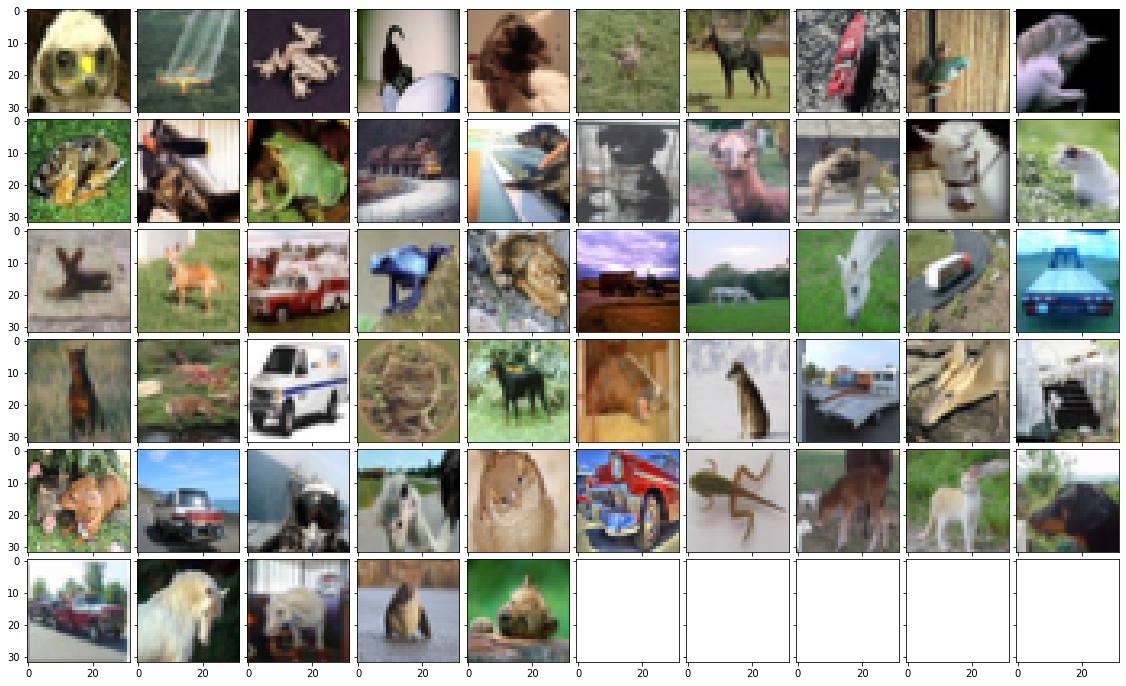

In [15]:
# Print the images that 5 models or less got right
threshold = 5
zero = img_preds10[img_preds10 <= threshold]
print("On CIFAR 10,", len(zero), "were misclassified by 0 -", threshold, "models. That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())

#### Images that 34 or more models got right

##### CIFAR 10

In [16]:
# Print the images that 34 models or more got right
threshold = 34
zero = img_preds101[img_preds101 >= threshold]
print("On CIFAR 10.1,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())

On CIFAR 10.1, 1768 were classified correctly by 34 or more model(s). That is 0.884 percent of the dataset.



##### CIFAR 10

In [17]:
# Print the images that 34 models or more got right
threshold = 34
zero = img_preds10[img_preds10 >= threshold]
print("On CIFAR 10,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())

On CIFAR 10, 9537 were classified correctly by 34 or more model(s). That is 0.9537 percent of the dataset.



### Results for Models Trained on Unaugmented Data

In [19]:
results_cifar10_noaug = results_cifar10[results_cifar10["randaug"]==False]
results_cifar101_noaug = results_cifar101[results_cifar101["randaug"]==False]
print("CIFAR10 len:", len(results_cifar10_noaug), "CIFAR10.1 len:", len(results_cifar101_noaug))

CIFAR10 len: 21 CIFAR10.1 len: 21


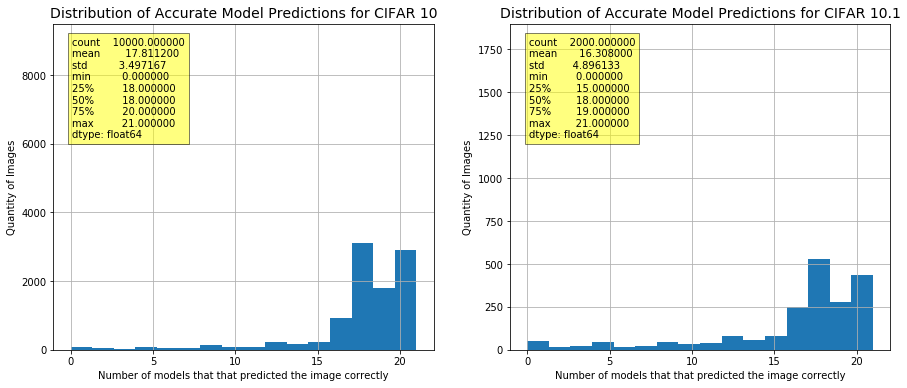

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10_noaug.columns if 'img' in col]
img_preds10 = results_cifar10_noaug[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=20)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_noaug.columns if 'img' in col]
img_preds101 = results_cifar101_noaug[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=20)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

c10_ymax = 9500
c101_ymax = 1900

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)

pass

#### Images that every model missed

###### CIFAR 10.1

On CIFAR 10.1, 27 were misclassified by every model. That is 0.0135 percent of the dataset.

Correct Labels by Row:
airplane automobile automobile automobile automobile automobile automobile automobile automobile automobile
automobile automobile automobile bird bird cat cat cat cat dog
dog dog dog dog frog horse ship


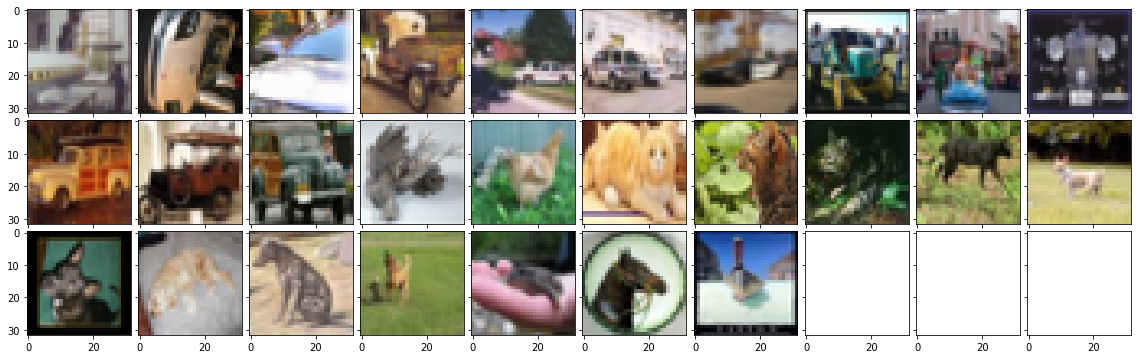

In [21]:
# Print the images that no model got right
zero = img_preds101[img_preds101 == 0]
print("On CIFAR 10.1,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())
unaug_cifar101_allwrong = zero.index

On CIFAR 10, 37 were misclassified by every model. That is 0.0185 percent of the dataset.

Correct Labels by Row:
airplane ship dog ship frog automobile horse airplane cat dog
dog horse dog horse truck horse truck bird horse cat
dog dog cat truck dog dog dog automobile automobile cat
bird bird cat automobile horse truck automobile


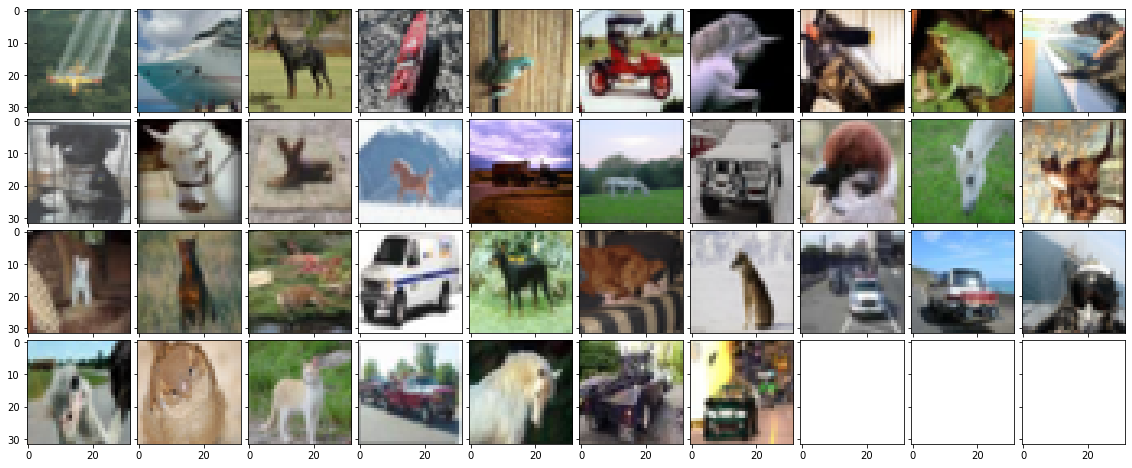

In [22]:
zero = img_preds10[img_preds10 == 0]
print("On CIFAR 10,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())
unaug_cifar10_allwrong = zero.index

#### Images that X models or less predicted correctly

##### CIFAR 10

In [23]:
# Print the images that at least X models got right
threshold = 7
zero = img_preds10[img_preds10 >= threshold]
print("On CIFAR 10,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())
unaug_cifar10_allright = zero.index

On CIFAR 10, 9734 were classified correctly by 7 or more model(s). That is 0.9734 percent of the dataset.



##### CIFAR 10.1

In [24]:
# Print the images that at least X models got right
threshold = 7
zero = img_preds101[img_preds101 >= threshold]
print("On CIFAR 10.1,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())
unaug_cifar101_allright = zero.index

On CIFAR 10.1, 1850 were classified correctly by 7 or more model(s). That is 0.925 percent of the dataset.



### Results for Models Trained on Augmented Data
#### Images that every model missed

###### CIFAR 10.1

In [25]:
results_cifar10_aug = results_cifar10[results_cifar10["randaug"]==True]
results_cifar101_aug = results_cifar101[results_cifar101["randaug"]==True]
print("CIFAR10 len:", len(results_cifar10_aug), "CIFAR10.1 len:", len(results_cifar101_aug))

CIFAR10 len: 64 CIFAR10.1 len: 64


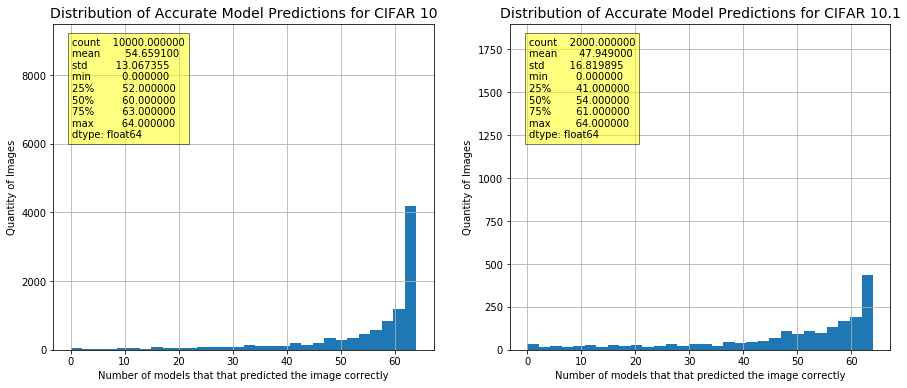

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10_aug.columns if 'img' in col]
img_preds10 = results_cifar10_aug[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=30)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_aug.columns if 'img' in col]
img_preds101 = results_cifar101_aug[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=30)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)
pass

#### Images that every model missed

###### CIFAR 10.1

On CIFAR 10.1, 12 were misclassified by every model. That is 0.006 percent of the dataset.

Correct Labels by Row:
airplane automobile automobile automobile automobile automobile cat cat dog dog
horse horse


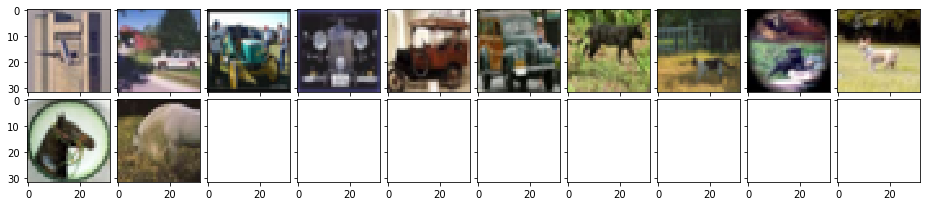

In [27]:
# Print the images that no model got right
zero = img_preds101[img_preds101 == 0]
print("On CIFAR 10.1,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())

###### CIFAR 10

On CIFAR 10, 17 were misclassified by every model. That is 0.0017 percent of the dataset.

Correct Labels by Row:
airplane automobile truck bird frog deer truck horse horse truck
truck cat horse cat bird frog automobile


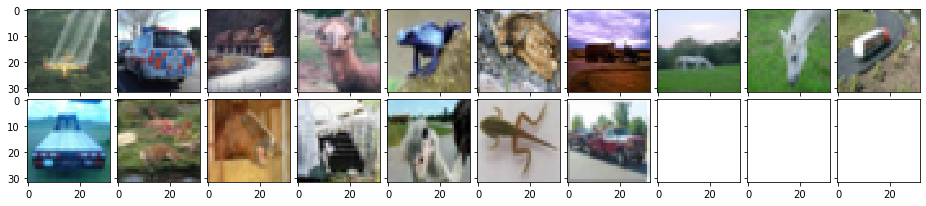

In [28]:
zero = img_preds10[img_preds10 == 0]
print("On CIFAR 10,", len(zero), "were misclassified by every model. That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())

#### Images that at least X models predicted correctly

###### CIFAR 10

In [29]:
# Print the images that no model got right
threshold = 29
zero = img_preds10[img_preds10 >= threshold]
print("On CIFAR 10,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR10), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR10, test_labels_CIFAR10, zero.keys())

On CIFAR 10, 9316 were classified correctly by 29 or more model(s). That is 0.9316 percent of the dataset.



###### CIFAR 10.1

In [31]:
# Print the images that no model got right
threshold = 29
zero = img_preds101[img_preds101 >= threshold]
print("On CIFAR 10.1,", len(zero), "were classified correctly by", threshold, "or more model(s). That is", \
      len(zero)/len(test_labels_CIFAR101), "percent of the dataset.\n")
#print_imgs(test_data_CIFAR101, test_labels_CIFAR101, zero.keys())

On CIFAR 10.1, 1688 were classified correctly by 29 or more model(s). That is 0.844 percent of the dataset.



## Focus on RandAugment N=2, M=5

In [32]:
results_cifar10_2x5 = results_cifar10[(results_cifar10["N"]==2) & (results_cifar10["M"]==5)]
results_cifar101_2x5 = results_cifar101[(results_cifar101["N"]==2) & (results_cifar101["M"]==5)]
print("CIFAR10 len:", len(results_cifar10_2x5), "CIFAR10.1 len:", len(results_cifar101_2x5))

CIFAR10 len: 16 CIFAR10.1 len: 16


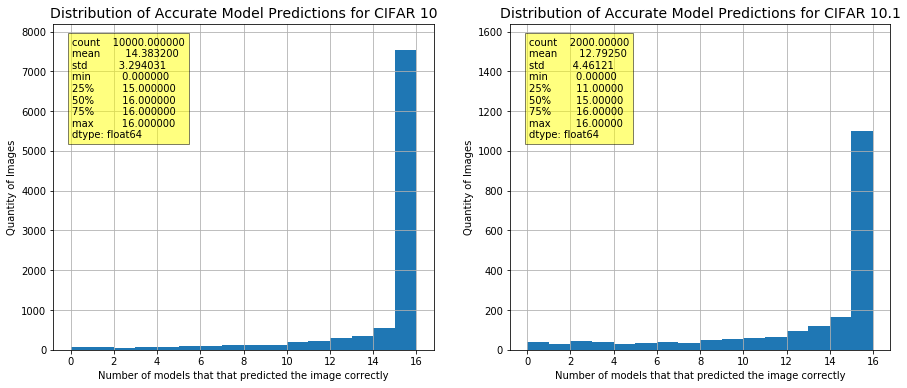

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

c10_ymax = 8200
c101_ymax = 1640

imgs = [col for col in results_cifar10_2x5.columns if 'img' in col]
img_preds10 = results_cifar10_2x5[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=16)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))
ax1.set_ylim(0,c10_ymax)


imgs = [col for col in results_cifar101_2x5.columns if 'img' in col]
img_preds101 = results_cifar101_2x5[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=16)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))
ax2.set_ylim(0,c101_ymax)
pass

## Focus on RandAugment N=2, M=20

In [34]:
results_cifar10_2x20 = results_cifar10[(results_cifar10["N"]==2) & (results_cifar10["M"]==20)]
results_cifar101_2x20 = results_cifar101[(results_cifar101["N"]==2) & (results_cifar101["M"]==20)]
print("CIFAR10 len:", len(results_cifar10_2x20), "CIFAR10.1 len:", len(results_cifar101_2x20))

CIFAR10 len: 16 CIFAR10.1 len: 16


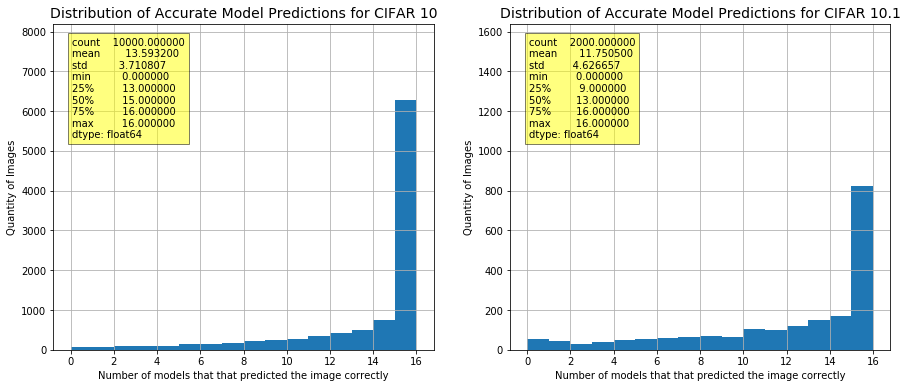

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10_2x20.columns if 'img' in col]
img_preds10 = results_cifar10_2x20[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=16)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_2x20.columns if 'img' in col]
img_preds101 = results_cifar101_2x20[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=16)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)
pass

## Focus on RandAugment N=3,M=20

In [36]:
results_cifar10_3x20 = results_cifar10[(results_cifar10["N"]==3) & (results_cifar10["M"]==20)]
results_cifar101_3x20 = results_cifar101[(results_cifar101["N"]==3) & (results_cifar101["M"]==20)]
print("CIFAR10 len:", len(results_cifar101_3x20), "CIFAR10.1 len:", len(results_cifar101_3x20))

CIFAR10 len: 16 CIFAR10.1 len: 16


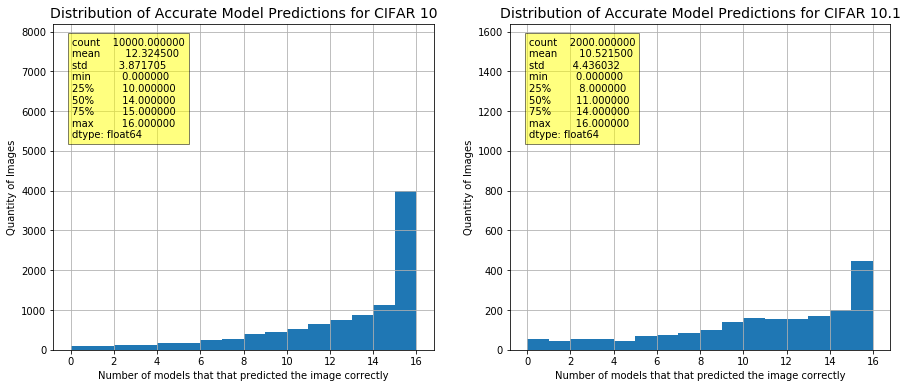

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10_3x20.columns if 'img' in col]
img_preds10 = results_cifar10_3x20[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=16)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_3x20.columns if 'img' in col]
img_preds101 = results_cifar101_3x20[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=16)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)
pass

## Focus on RandAugment N=1,M=20

In [38]:
results_cifar10_1x20 = results_cifar10[(results_cifar10["N"]==1) & (results_cifar10["M"]==20)]
results_cifar101_1x20 = results_cifar101[(results_cifar101["N"]==1) & (results_cifar101["M"]==20)]
print("CIFAR10 len:", len(results_cifar101_1x20), "CIFAR10.1 len:", len(results_cifar101_1x20))

CIFAR10 len: 16 CIFAR10.1 len: 16


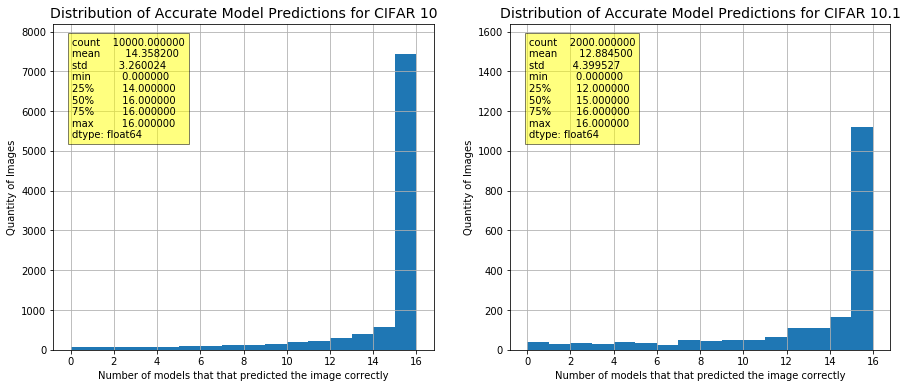

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cifar10_1x20.columns if 'img' in col]
img_preds10 = results_cifar10_1x20[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=16)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_1x20.columns if 'img' in col]
img_preds101 = results_cifar101_1x20[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=16)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)
pass

## Focus on CutMix alpha=1

In [58]:
results_cutmix = results_cifar10[(results_cifar10["model"]=="../model_results/densenet_BC_100_12_cm_1_1")
                                 | (results_cifar10["model"]=="../model_results/wrn_28_10_cm_1_1")
                                | (results_cifar10["model"]=="../model_results/resnet_basic_32_cm_1_1")
                                | (results_cifar10["model"]=="../model_results/resnext_29_4x64_cm_1_1")]

results_cifar101_cutmix = results_cifar101[(results_cifar101["model"]=="../model_results/densenet_BC_100_12_cm_1_1") 
                                 | (results_cifar10["model"]=="../model_results/wrn_28_10_cm_1_1")
                                | (results_cifar10["model"]=="../model_results/resnet_basic_32_cm_1_1")
                                | (results_cifar10["model"]=="../model_results/resnext_29_4x64_cm_1_1")]
print("CIFAR10 len:", len(results_cutmix), "CIFAR10.1 len:", len(results_cifar101_cutmix))

CIFAR10 len: 8 CIFAR10.1 len: 8


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


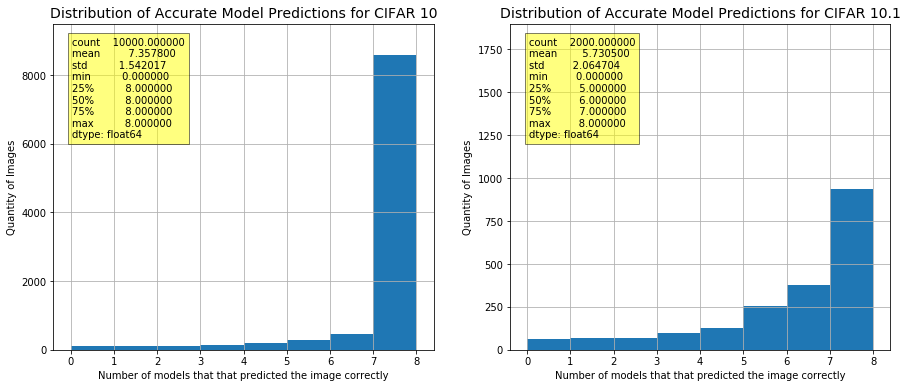

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 6))

imgs = [col for col in results_cutmix.columns if 'img' in col]
img_preds10 = results_cutmix[imgs].sum(axis=0)
img_preds10.hist(ax=ax1,bins=8)
ax1.set_xlabel('Number of models that that predicted the image correctly')
ax1.set_ylabel('Quantity of Images')
ax1.set_title('Distribution of Accurate Model Predictions for CIFAR 10', fontsize=14)
ax1.annotate(str(img_preds10.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))


imgs = [col for col in results_cifar101_cutmix.columns if 'img' in col]
img_preds101 = results_cifar101_cutmix[imgs].sum(axis=0)
img_preds101.hist(ax=ax2,bins=8)
ax2.set_xlabel('Number of models that that predicted the image correctly')
ax2.set_ylabel('Quantity of Images')
ax2.set_title('Distribution of Accurate Model Predictions for CIFAR 10.1', fontsize=14)
ax2.annotate(str(img_preds101.describe()), xy=(0.05, 0.65), xycoords='axes fraction',
             backgroundcolor='w', bbox = dict(facecolor='yellow', alpha=0.5))

ax1.set_ylim(0,c10_ymax)
ax2.set_ylim(0,c101_ymax)
pass